In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import collections

In [18]:
# Read user IDs and usernames
user_ids = {}
with open('/kaggle/input/reddit-top-minds/file1_users.txt', 'r') as file:
    for line in file:
        id, user = line.strip().split()
        user_ids[int(id)] = user

# Read edges
edges = []
with open('/kaggle/input/reddit-top-minds/file2_edges.txt', 'r') as file:
    for line in file:
        id1, id2 = map(int, line.strip().split())
        edges.append((id1, id2))

# Read edges with negativity scores
edge_negativity_scores = {}
with open('/kaggle/input/reddit-top-minds/file3_edges_negativity_scores.txt', 'r') as file:
    for line in file:
        id1, id2, score = line.strip().split()
        edge_negativity_scores[(int(id1), int(id2))] = float(score)

# Read mean negativity scores for users
mean_negativity = {}
with open('/kaggle/input/reddit-top-minds/file5_users_mean_negativity.txt', 'r') as file:
    for line in file:
        id, mean_score = line.strip().split()
        mean_negativity[int(id)] = float(mean_score)


**1. Description of the network**

* Data extracted from this moths's top 20 posts from TopMindsOfReddit subreddit  
* N = 806 nodes as reddit users
* L = 2082 edges representing replies(comments) between users
* The edges have also a sentiment score (computed from user comment)

In [19]:
G = nx.MultiGraph()
for user_id in user_ids:
    G.add_node(user_id)

for edge in edges:
    G.add_edge(*edge)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 806
Number of edges: 2082


**2. Network properties**

The network is connected, so it has only 1 connected component

* Average degree: 5.166
* Min degree= 1
* Max degree= 580
* Size of the largest connected component: 806
* Diameter: 10
* Average shortest path length: 3.391 
* Average clustering coefficient: 0.118 
* Edge density: 0.006

In [20]:
degrees = [G.degree[node] for node in G]
kmin = np.min(degrees)
kmax = np.max(degrees)
kavg = np.mean(degrees)

print("Average degree=", kavg)
print("Min degree=", kmin)
print("Max degree=", kmax)

Average degree= 5.166253101736973
Min degree= 1
Max degree= 580


Avg degree is closer to the min degree, while max degree is much higher than min/mean (skewed degree distribution) => first indication the network could be a power-low (or some heavy-tailed distribution), but this is not yet fully confirmed.

In [21]:
is_connected = nx.is_connected(G)
print("Is the graph connected?", is_connected)

Is the graph connected? True


In [22]:
diameter = nx.diameter(G)
print("Diameter of G:", diameter)

nx.shortest_path(G)
average_shortest_path_length = nx.average_shortest_path_length(G)
print("Average shortest path length:", average_shortest_path_length)

# Convert multigraph to simple graph to cpmo=pute clustering coefficient
G_simple = nx.Graph()
for u, v in G.edges():
    G_simple.add_edge(u, v)
    
# Average clustering coefficient
average_clustering_coefficient = nx.average_clustering(G_simple)
print("Average clustering coefficient:", average_clustering_coefficient)

# Edge density
edge_density = nx.density(G)
print("Edge density:", edge_density)

Diameter of G: 10
Average shortest path length: 3.3918406978715536
Average clustering coefficient: 0.11824719938697259
Edge density: 0.006417705716443445


**Is the network highly clustered?**

avg clustering coeff >> edge density, moderate level of clustering, but it is sparse overall (because of the low edge density). This is typical for a real-world network.

**3.Plots**

* degree distribution
* clustering coefficient distribution
* betweenness centrality distribution
* connected components size distribution

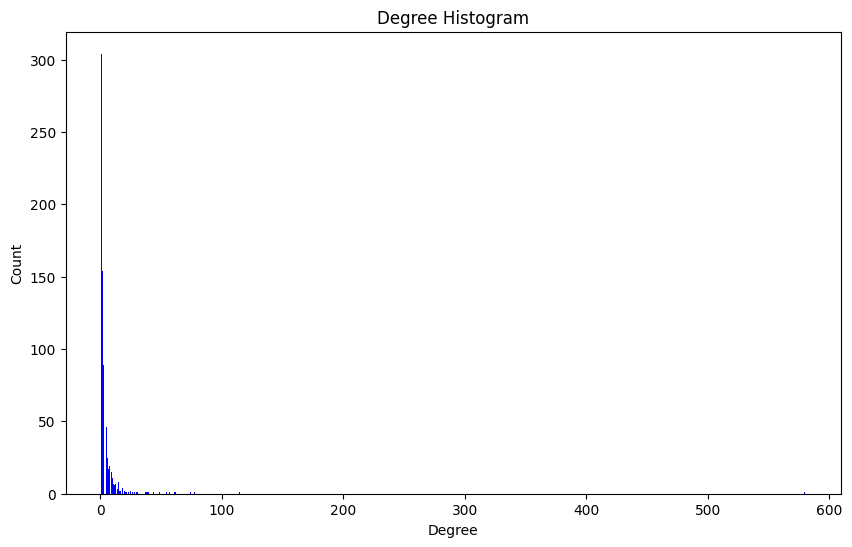

In [23]:
import matplotlib.pyplot as plt
import collections
import numpy as np

# Degree Distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

plt.figure(figsize=(10, 6))
plt.bar(deg, cnt, width=0.80, color='b')
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()


**Degree Histogram Analysis**

* majority of nodes have a low degree
* there is a node with an extremely high degree (580), which acts like a hub 
* distribution may suggest a scale-free property

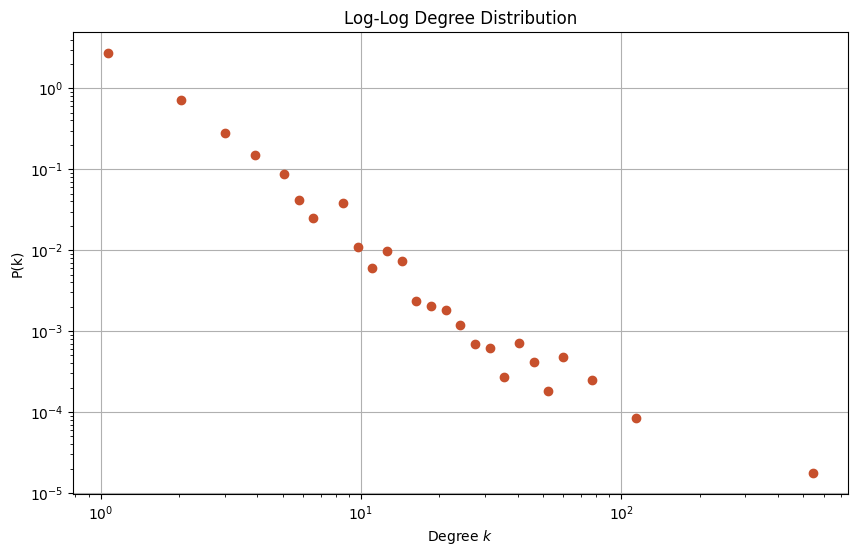

In [24]:
# Log-log plot of degree distribution
kmin = np.min(degree_sequence)
kmax = np.max(degree_sequence)
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=50)
density, _ = np.histogram(degree_sequence, bins=bin_edges, density=True)

fig = plt.figure(figsize=(10, 6))
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)
plt.loglog(x, density, marker='o', linestyle='none', color='#c7502c')
plt.xlabel("Degree $k$")
plt.ylabel("P(k)")
plt.title("Log-Log Degree Distribution")
plt.grid(True)
plt.show()

**Log Log Plot Analysis**
* from earlier we know that the avg degree is closer to the min degree
* the degree distribution follows a straight line, characteristic of scale-free network

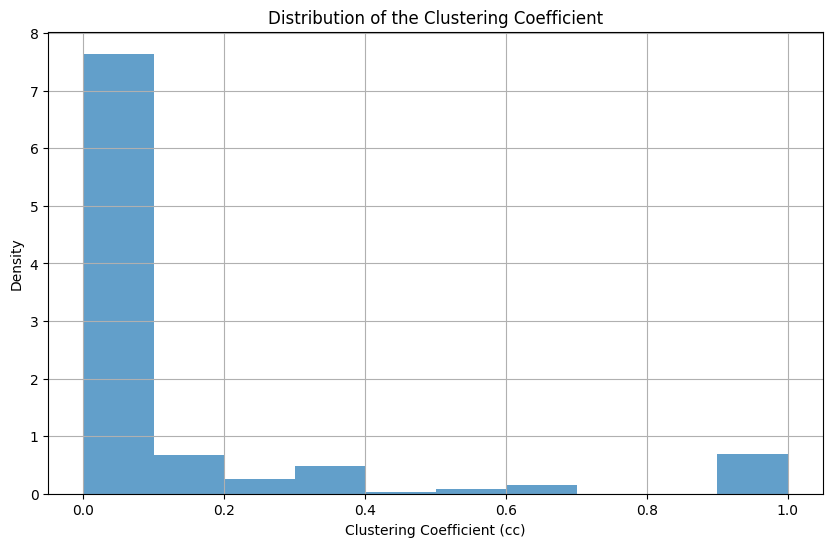

In [25]:
# Clustering Coefficient Distribution
cc = nx.clustering(G_simple)
vcc = list(cc.values())

plt.figure(figsize=(10, 6))
plt.hist(vcc, bins=10, density=True, alpha=0.7)
plt.title("Distribution of the Clustering Coefficient")
plt.xlabel("Clustering Coefficient (cc)")
plt.ylabel("Density")
plt.grid(True)
plt.show()


**Clustering Coeff Plot Analysis**

* the nodes with a clustering coefficient of 0 do not form triangles with their neighbors
* low clustering for most nodes, indicating that many nodes are part of sparse local neighborhoods
* presence of highly clustered nodes with high clustering coefficients (close to 1)

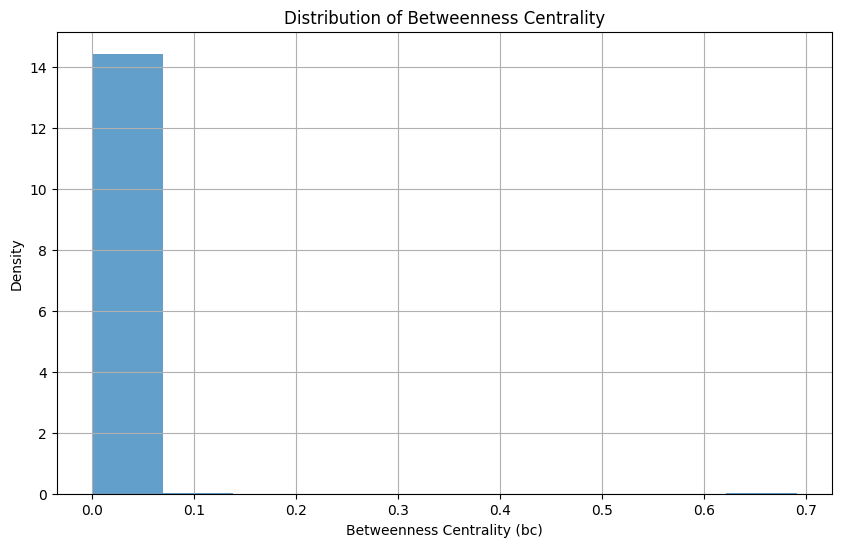

In [26]:
# Betweenness Centrality Distribution
betweenness_dict = nx.betweenness_centrality(G) 
betweenness_values = list(betweenness_dict.values()) 

plt.figure(figsize=(10, 6))
plt.hist(betweenness_values, bins=10, density=True, alpha=0.7)
plt.title("Distribution of Betweenness Centrality")
plt.xlabel("Betweenness Centrality (bc)")
plt.ylabel("Density")
plt.grid(True)
plt.show()

**Betweenness Centrality Plot Analysis**

* distribution is highly skewed, with most nodes having a very low betweenness centrality.

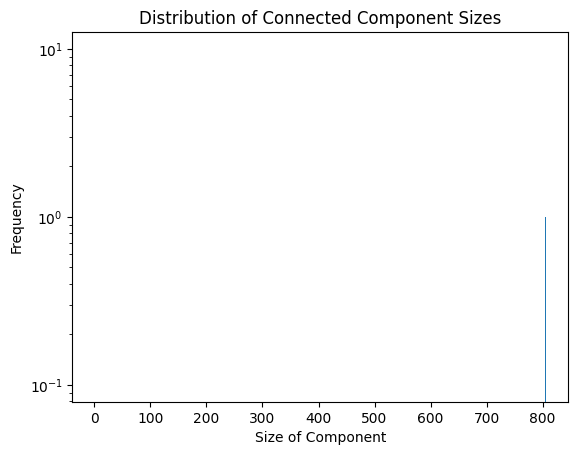

In [27]:
connected_components = sorted(nx.connected_components(G), key=len, reverse=True)
component_sizes = [len(c) for c in connected_components]

plt.hist(component_sizes, bins=range(1, max(component_sizes)+1), density=True)
plt.title("Distribution of Connected Component Sizes")
plt.xlabel("Size of Component")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

**Connected Component Plot Analysis**

* the network has only one connected component, so we see only one bar on the plot
* this is not meaningful for our network

In [28]:
degrees = dict(G.degree())

# Node with maximum degree
max_degree_node = max(degrees, key=degrees.get)

# Node with maximum clustering coefficient
clustering = nx.clustering(G_simple)
max_clustering_node = max(clustering, key=clustering.get)

# Node with the highest degree centrality
degree_centrality = nx.degree_centrality(G)
max_degree_centrality_node = max(degree_centrality, key=degree_centrality.get)

# Node with the highest betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
max_betweenness_node = max(betweenness_centrality, key=betweenness_centrality.get)

# Node with the highest closeness centrality
closeness_centrality = nx.closeness_centrality(G)
max_closeness_node = max(closeness_centrality, key=closeness_centrality.get)

# Node with the highest eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G_simple)
max_eigenvector_node = max(eigenvector_centrality, key=eigenvector_centrality.get)

print(f"Node with the highest degree: {max_degree_node} (Degree: {degrees[max_degree_node]})")
print(f"Node with the highest clustering coefficient: {max_clustering_node} (Clustering Coefficient: {clustering[max_clustering_node]})")
print(f"Node with the highest degree centrality: {max_degree_centrality_node} (Degree Centrality: {degree_centrality[max_degree_centrality_node]})")
print(f"Node with the highest betweenness centrality: {max_betweenness_node} (Betweenness Centrality: {betweenness_centrality[max_betweenness_node]})")
print(f"Node with the highest closeness centrality: {max_closeness_node} (Closeness Centrality: {closeness_centrality[max_closeness_node]})")
print(f"Node with the highest eigenvector centrality: {max_eigenvector_node} (Eigenvector Centrality: {eigenvector_centrality[max_eigenvector_node]})")

Node with the highest degree: 1 (Degree: 580)
Node with the highest clustering coefficient: 76 (Clustering Coefficient: 1.0)
Node with the highest degree centrality: 1 (Degree Centrality: 0.7204968944099379)
Node with the highest betweenness centrality: 1 (Betweenness Centrality: 0.6904068443733877)
Node with the highest closeness centrality: 1 (Closeness Centrality: 0.540268456375839)
Node with the highest eigenvector centrality: 1 (Eigenvector Centrality: 0.6482140382178376)


* node 1 seems to be an extremely important node, likely acting as a central hub
* node 76 has a high clustering coefficient and it could be central within its local community

**Visualization of the network**

* **Basic Network Visualization**: initial exploration of the network to understand its general structure and connectivity
* **Visualizations based on edge sentiment**: the edges will be colored based on the sentiment score (red for negative, green for positive) 
* **Visualizations based on node sentiment**: the nodes will be colored based on the mean sentiment score after analyzing all interactions (red for negative, green for positive)
* **Circular Layout Visualization**: circular layout, useful for spotting symmetries
* **Network Visualization with Node Degree Size**: useful for quickly identifying important nodes or hubs within the network
* **Community Detection Visualization**: segregates communities within the network
* **Betweenness Centrality Visualization**: emphasizes nodes that serve as critical connectors or bridges within the network




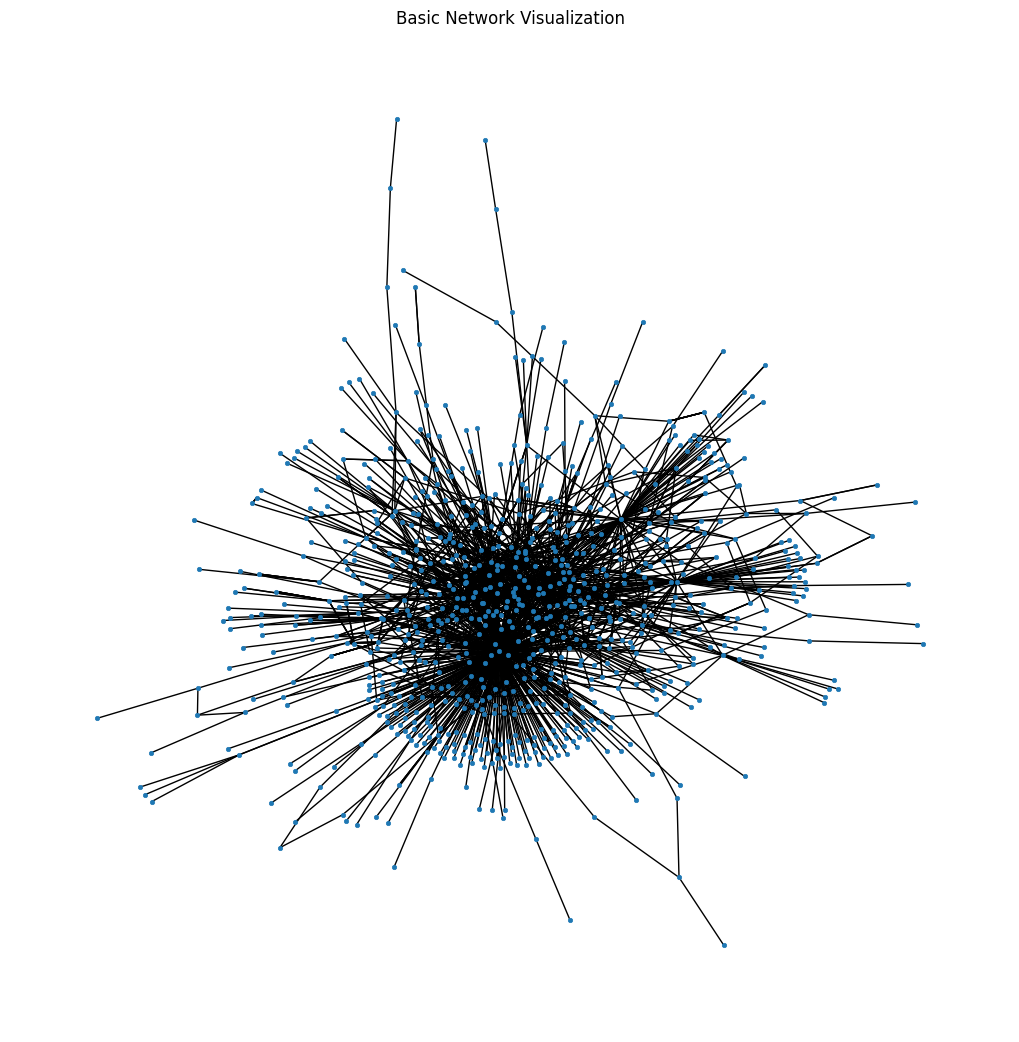

In [29]:
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=False, node_size=10, linewidths=0.5)
plt.title("Basic Network Visualization")
plt.show()



In [30]:
# import networkx as nx
# import numpy as np

# # Read user IDs and usernames
# user_ids = {}
# with open('/kaggle/input/reddit-top-minds/file1_users.txt', 'r') as file:
#     for line in file:
#         id, user = line.strip().split()
#         user_ids[int(id)] = user

# # Read edges
# edges = []
# with open('/kaggle/input/reddit-top-minds/file2_edges.txt', 'r') as file:
#     for line in file:
#         id1, id2 = map(int, line.strip().split())
#         edges.append((id1, id2))

# # Read edges with negativity scores
# edge_negativity_scores = {}
# with open('/kaggle/input/reddit-top-minds/file3_edges_negativity_scores.txt', 'r') as file:
#     for line in file:
#         id1, id2, score = line.strip().split()
#         edge_negativity_scores[(int(id1), int(id2))] = float(score)

# # Read mean negativity scores for users
# mean_negativity = {}
# with open('/kaggle/input/reddit-top-minds/file5_users_mean_negativity.txt', 'r') as file:
#     for line in file:
#         id, mean_score = line.strip().split()
#         mean_negativity[int(id)] = float(mean_score)

# # Create the graph
# G = nx.MultiGraph()
# for user_id in user_ids:
#     G.add_node(user_id, username=user_ids[user_id], mean_negativity=mean_negativity.get(user_id, 0.5))

# for edge in edges:
#     negativity_score = edge_negativity_scores.get((edge[0], edge[1]), 0.5)
#     G.add_edge(edge[0], edge[1], negativity_score=negativity_score)

# print("Number of nodes:", G.number_of_nodes())
# print("Number of edges:", G.number_of_edges())

# degrees = [G.degree[node] for node in G]
# kmin = np.min(degrees)
# kmax = np.max(degrees)
# kavg = np.mean(degrees)

# print("Average degree=", kavg)
# print("Min degree=", kmin)
# print("Max degree=", kmax)

# # Export the graph to a GEXF file
# nx.write_gexf(G, "network_graph_with_negativity.gexf")


In [33]:
# node_colors = ['red' if mean_negativity.get(node, 0.5) > 0.5 else 'green' for node in G.nodes()]

# plt.figure(figsize=(20, 20))
# nx.draw(G, pos, with_labels=False, node_size=100, font_size=8, node_color=node_colors, alpha=0.7)
# plt.title("Network Visualization with Node Colors by Mean Negativity Score")
# plt.show()

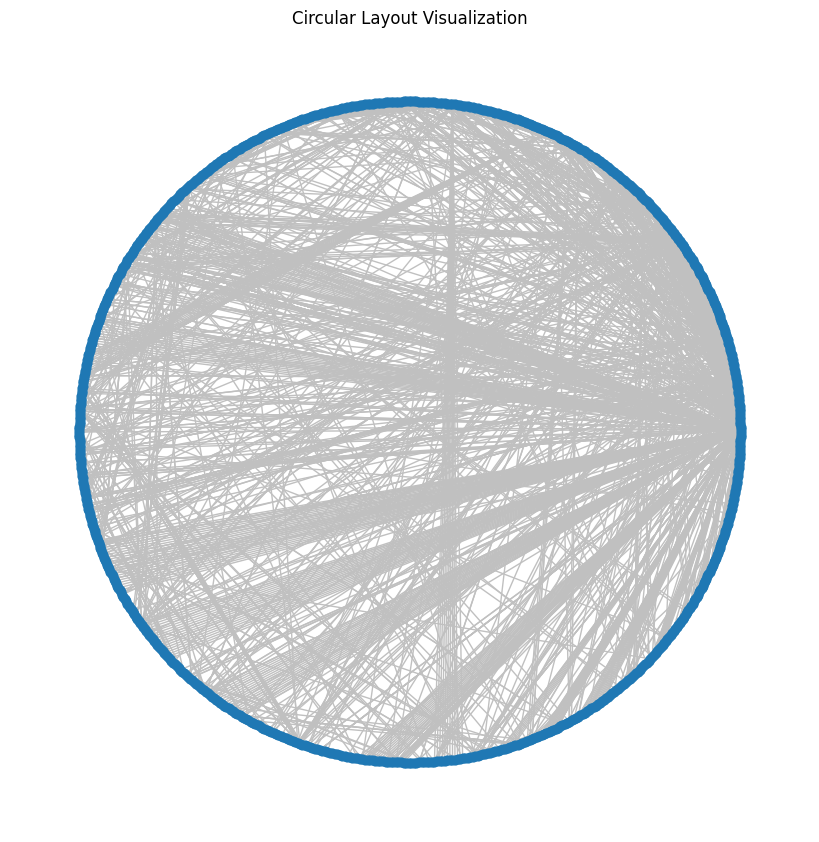

In [34]:
fig = plt.figure(figsize=(8, 8))
nx.draw_circular(G, node_size=40, with_labels=False, edge_color='silver')
plt.title("Circular Layout Visualization")
plt.show()

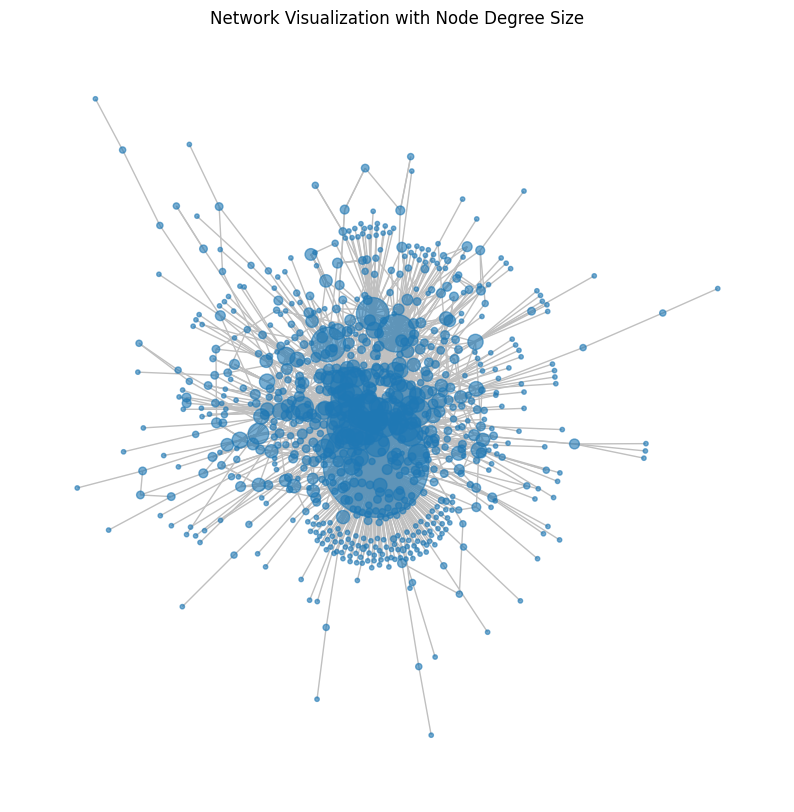

In [35]:
node_degree = dict(G.degree())
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=[v * 10 for v in node_degree.values()], alpha=0.6)
nx.draw_networkx_edges(G, pos, edge_color='silver')
plt.axis('off')
plt.title("Network Visualization with Node Degree Size")
plt.show()

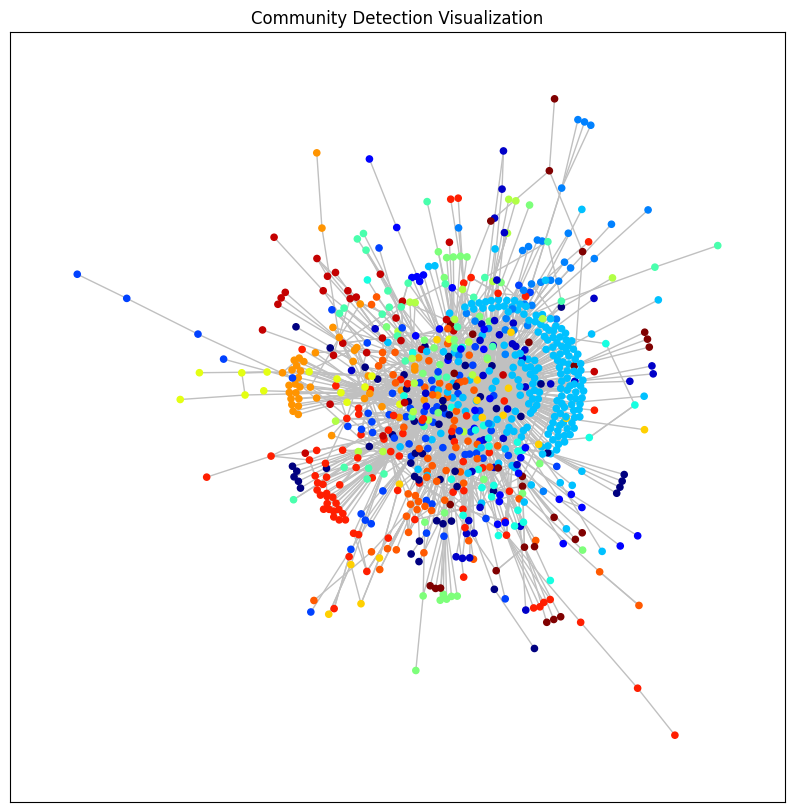

In [36]:
import community as community_louvain

partition = community_louvain.best_partition(G)
community_colors = [partition[node] for node in G.nodes()]
layout = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, pos=layout, node_color=community_colors, with_labels=False,
                 node_size=20, edge_color="silver", cmap=plt.cm.jet)
plt.title("Community Detection Visualization")
plt.show()

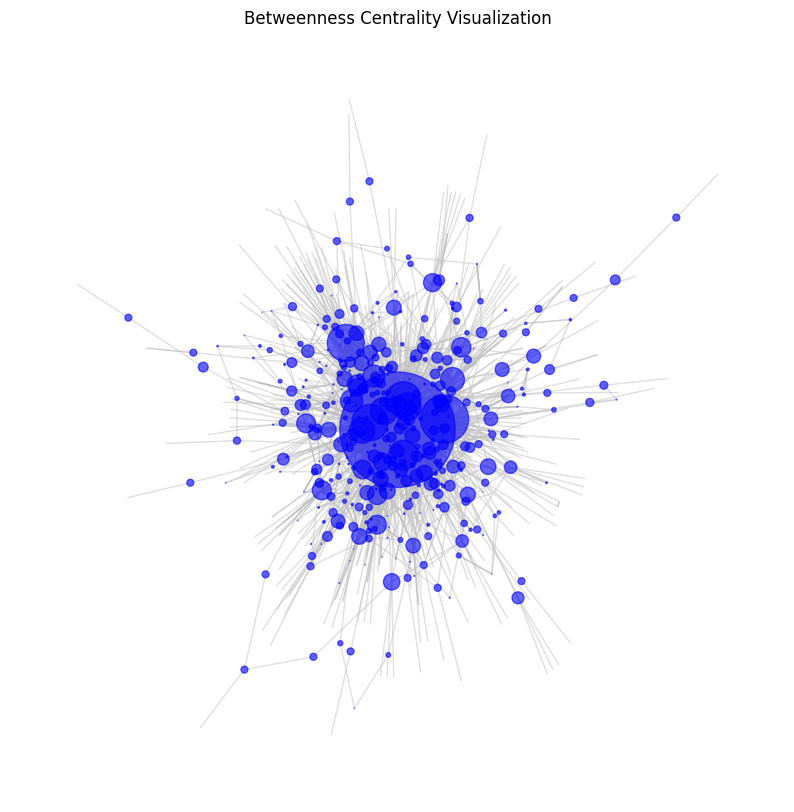

In [37]:
betweenness = nx.betweenness_centrality(G)
node_size = [v * 10000 for v in betweenness.values()]
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='blue', alpha=0.6)
nx.draw_networkx_edges(G, pos, edge_color='silver', alpha=0.5)
plt.title("Betweenness Centrality Visualization")
plt.axis('off') 
plt.show()